In [116]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
from src.visualization.vis_data import *
import seaborn as sns
output_notebook()
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [203]:
# start building dataset from scratch only perform this when new data files are added 
dataset = Dataset('Hanoi')
dataset.build_all_data(build_fire=False, build_holiday=False)

Averaging data from 3 stations


In [137]:
dataset = Dataset('Hanoi')
dataset.load_()

# Pollution

Index(['PM2.5'], dtype='object')


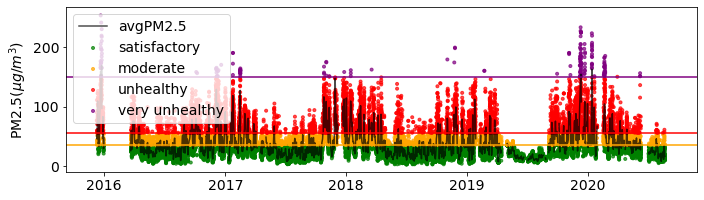

In [8]:
# plot the raw data
plot_all_pollutions(dataset.poll_df, city_name=dataset.city_name)

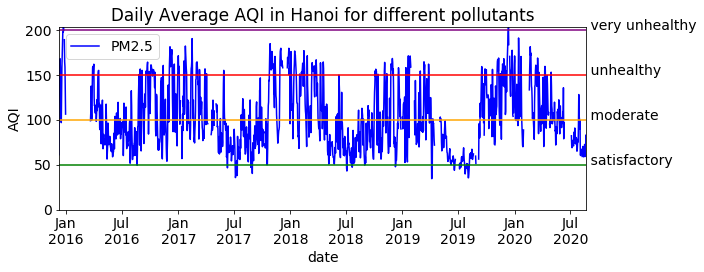

In [15]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

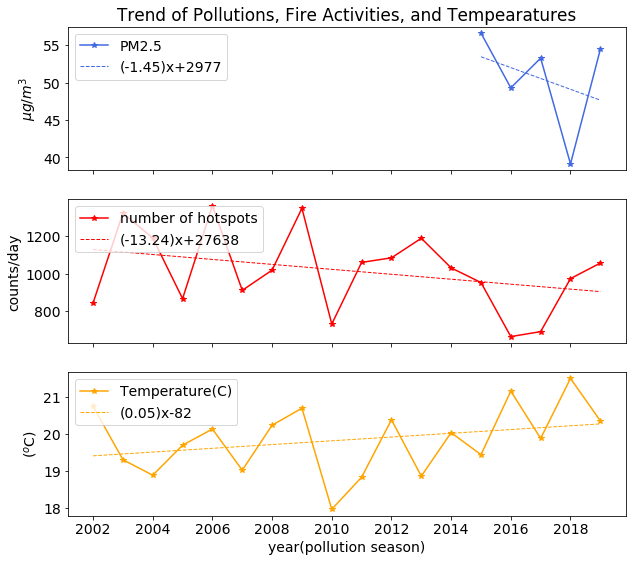

In [19]:
ax, year_avg = plot_yearly_ln(dataset, filename=dataset.report_folder + 'compare_ln_trends.png')

aqi 100 in  08-22 to 06-08
aqi 150 in  10-08 to 04-16


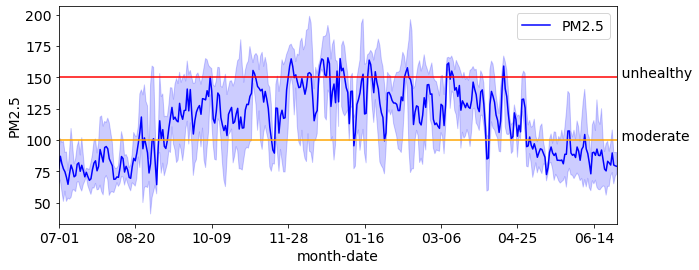

In [20]:
plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25.png')

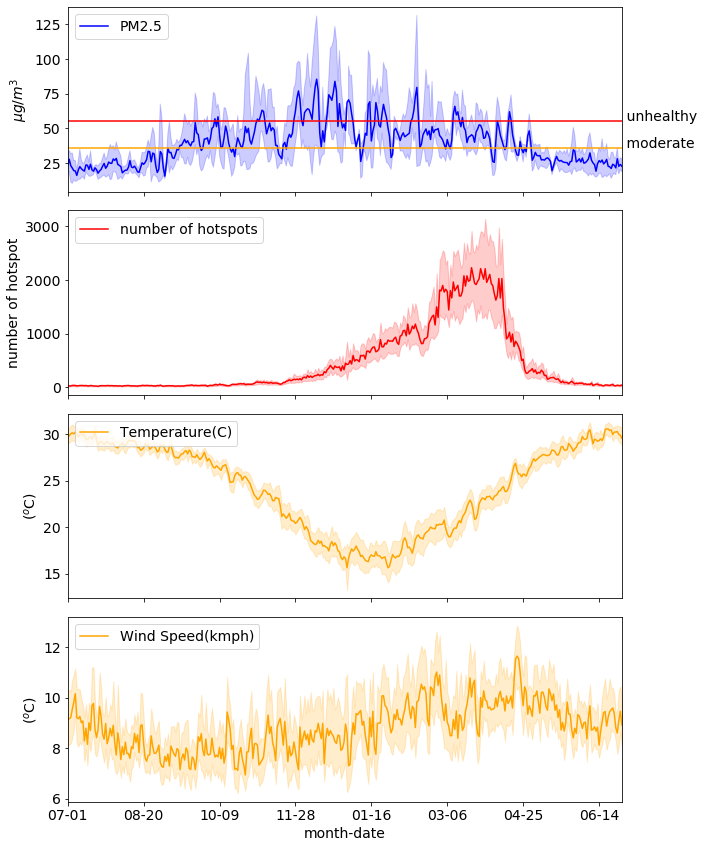

In [21]:
compare_seson_avg(dataset, agg='mean', filename=dataset.report_folder + 'fire_PM25_season.png')

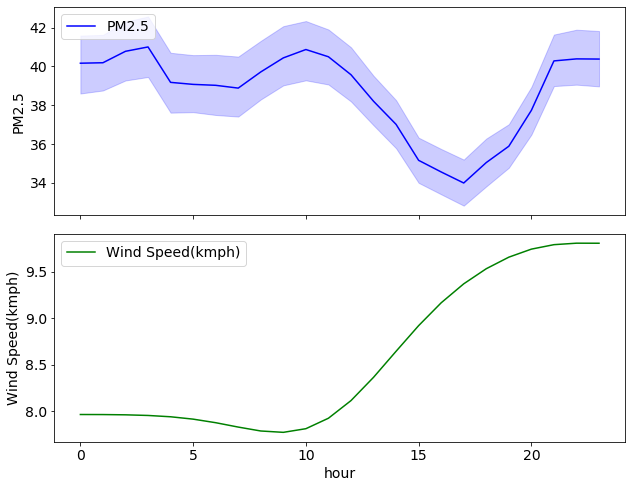

In [20]:
_, ax = plt.subplots(2, 1, figsize=(9, 7), sharex=True)
plot_hour_avg(dataset.poll_df.copy(), 'PM2.5', ax[0],  color='blue')
 
df = df.groupby('time_of_day').mean().rolling(2, min_periods=0,center=True).mean()
ax[1].plot(df['Wind Speed(kmph)'], color='green', label='Wind Speed(kmph)')
ax[1].set_ylabel('Wind Speed(kmph)')
ax[1].set_xlabel('hour')
ax[1].legend(loc='upper left')
plt.tight_layout()

# Map 

Fire map and power plants from https://endcoal.org/tracker/

In [130]:
dataset.city_info

x = merc_x(dataset.city_info['Longitude'])
y = merc_y(dataset.city_info['Latitude'])
#stepx = 2E5

stepx = 1E6
stepy = stepx

In [146]:
# select fire data 
fire = dataset.fire
i = 0
month_list = ['2019-03','2019-04']
month = month_list[i]
color = 'red'
fire1 = fire.loc[month:month_list[i+1]]

month_list = ['2018-12','2019-01']
month = month_list[i]
fire2 = fire.loc[month:month_list[i+1]]

In [147]:
# range bounds supplied in web mercator coordinates
p = figure(x_range=(x-1*stepx,x+1*stepx), y_range=(y-stepy*0.3, y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = dataset.city_name)
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

# add city center
p.scatter(x,y,color='red',line_color='black',size=10, legend_label=dataset.city_name)

# plot hotspots at the begining and end of winter season

p.scatter(fire1['long_km']*1000,fire1['lat_km']*1000,color='red',size=1, alpha=0.5,legend_label='fire in Mar 2019')

p.scatter(fire2['long_km']*1000,fire2['lat_km']*1000,color='blue',size=1, alpha=0.5, legend_label='fire in Dec 2018')

#add circles
labels = ['0-120km','120-400km','400-700km','700-1200km']

rs = [120, 400, 700, 1200]
rs.reverse()
colors = get_color(color_length=len(labels),cmap=cm.jet)
for i, (r, label, color) in enumerate(zip(rs, labels, colors)):
    if i ==3 or i ==2:
        alpha=0.4
    else:
        alpha=0.2
        
    xy = get_circle(x,y,r=r*1E3)
    p.patch(xy[0,:],xy[1,:],alpha=alpha,line_width=2,line_color='black',color=color, legend_label=label)
    
p.legend.location = "bottom_right"

show(p)

In [123]:
# list of power plants hear Hanoi
plants = [[20.4809977, 106.5604517, 'coal']]

# ML Model

In [174]:
dataset = Dataset('Hanoi')
dataset.load_()
dataset.feature_no_fire(fill_missing=True, cat_hour=True,group_hour=1)
fire_cols, *args = dataset.merge_fire()

data no fire has shape (35617, 37)
use default fire feature


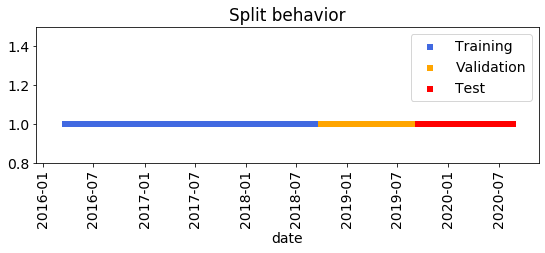

In [177]:
dataset.split_data(split_ratio=[0.6, 0.2, 0.2])
display_time_split(dataset.split_list)

In [180]:
model_meta = load_meta(dataset.model_folder + 'model_meta.json')

In [188]:
poll_meta = {'rolling_win': 1,
 'cat_hour': True,
 'fill_missing': True,
 'group_hour': 2}

In [189]:
split_lists = [[0.40, 0.3, 0.3], [0.45, 0.25, 0.3], [0.7, 0.3]]

In [190]:
poll_meta['split_lists'] = split_lists

In [192]:
model_meta['PM2.5'] = poll_meta

In [193]:
save_meta(dataset.model_folder + 'model_meta.json', model_meta)

In [ ]:
dataset, model, poll_meta = train_city_s1(city= 'Hanoi', pollutant='PM2.5')

data no fire has shape (34927, 21)
use default fire feature
=================optimize 1: find the best RF model=================
{'n_estimators': 160, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False} 0.019438650192425924
optimize 1 score {'val_r2_score': 0.20330309079236597, 'val_mean_squared_error': 435.078776612921, 'val_mean_absolute_error': 16.515898261179096}
=================optimize 2: remove unncessary columns=================
old cols length 24
drop wind_CALM
drop wind_N
drop day_of_week
drop fire_120_400
drop fire_700_1200
use columns ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_E', 'wind_S', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'time_of_day_[0, 3)', 'time_of_day_[3, 6)', 'time_of_day_[6, 9)', 'time_of_day_[9, 12)', 'time_of_day_[12, 15)', 'time_of_day_[15, 18)', 'time_of_day_[18, 21)', 'time_of_day_[21, 24)', 'fire_0_120', 'fire_400_700']
score after dropping columns {'r2_score': 0.2391

In [ ]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Hanoi', pollutant='PM2.5', split_list=[0.8, 0.2])

In [170]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Hanoi', pollutant='PM2.5', split_list=[0.7, 0.3])

data no fire has shape (34834, 21)
raw model performance {'test_r2_score': 0.3993001125091473, 'test_mean_squared_error': 463.9577153911805, 'test_mean_absolute_error': 14.291923906501218}
daily avg training error {'avg_trn_r2_score': 0.9474503276532106, 'avg_trn_mean_squared_error': 24.01795289578086, 'avg_trn_mean_absolute_error': 3.606799244784732}
daily avg test error {'avg_test_r2_score': 0.547453518289193, 'avg_test_mean_squared_error': 243.71162883421698, 'avg_test_mean_absolute_error': 11.289436600295556}


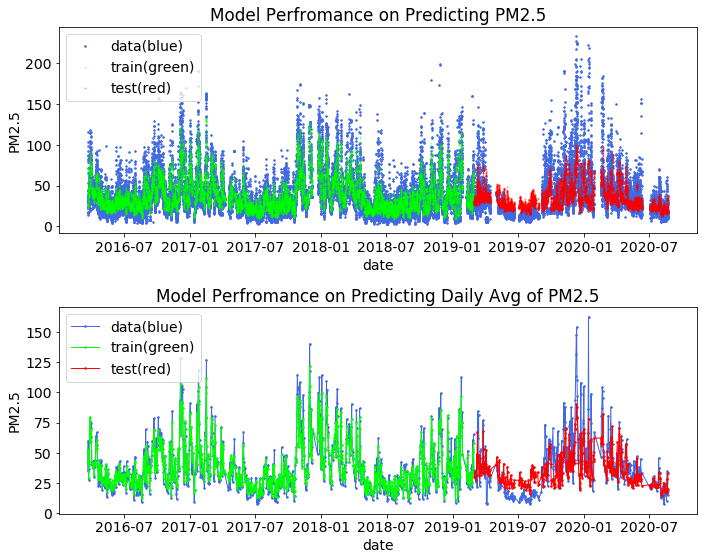

In [171]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)

In [201]:
dataset.poll_df.index.name

In [202]:
poll_df.index.name

'datetime'